In [29]:
import numpy as np
import sys
from model.Ribon.Franke import SinglePathwayModel
from model.Ribon.Franke import *
from model.Ribon.Franke_feature import get_trace_features
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import h5py

In [9]:
import torch
from sklearn.decomposition import PCA
from Feature.model import TimeContrastiveFeatureExtractor
from Feature.utils import load_checkpoint

In [3]:
base_dir = './Data/Curve_data'
data_file = h5py.File(os.path.join(base_dir, "Ribon_curve_0.h5"), 'r')
data_file.keys()

param_data = data_file.get('param_data')[...]
stats_data = data_file.get('stats_data')[...]

for i in range(1, 5):
    with h5py.File(os.path.join(base_dir, "Ribon_curve_{}.h5".format(i)), 'r') as data_file:
        sub_param_data = data_file.get('param_data')[...]
        sub_stats_data = data_file.get('stats_data')[...]
        param_data = np.concatenate((param_data, sub_param_data), axis=0)
        stats_data = np.concatenate((stats_data, sub_stats_data), axis=0)

In [6]:
tcl = TimeContrastiveFeatureExtractor(3, 18)

In [7]:
stats_data.shape

(10000, 15996)

In [8]:
!export CUDA_VISIBLE_DEVICES=15

In [11]:
checkpoint = load_checkpoint("../../Feature/TimeContrastive/time_contrastive.h5")
tcl.net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
tcl.net.cuda()

TimeContrastiveNeuralNetwork(
  (extractor): ResNet(
    (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [38]:
feature_tensor = None
batch = 10
for i in range(0, param_data.shape[0], batch):
    with torch.no_grad():
        print("Processing batch {}".format(i), end='\r')
        d = stats_data[i:i+batch].astype(np.float32).reshape(batch, 1, -1)
        d = torch.from_numpy(d).cuda()
        feature = tcl.get_feature(d).reshape(batch, -1)
        if feature_tensor is None:
            feature_tensor = feature
        else:
            feature_tensor = np.concatenate((feature_tensor, feature), axis=0)

In [39]:
feature_tensor[0].shape

(256000,)

In [40]:
pca = PCA(n_components=3)

In [41]:
pca.fit(feature_tensor)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [42]:
feature_3d = pca.transform(feature_tensor)

In [43]:
feature_3d.shape

(10000, 3)

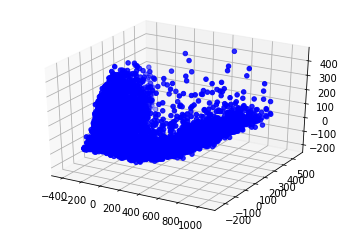

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature_3d[:, 0], feature_3d[:, 1], feature_3d[:, 2], c='b')

In [45]:
PCA_matrix = [np.load('./Data/PCA/PCA_{}.npy'.format(i)) for i in range(3)]

In [47]:
PCA_feature = list()
index_list = [0, 5000, 10000, 15996]
for i in range(3):
    f = np.matmul(stats_data[:, index_list[i]:index_list[i+1]], PCA_matrix[i].T)
    PCA_feature.append(f)

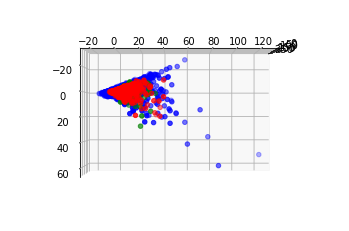

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=180, azim=0)
ax.scatter(PCA_feature[0][:, 0], PCA_feature[0][:, 1], PCA_feature[0][:, 2], c='b')
ax.scatter(PCA_feature[1][:, 0], PCA_feature[1][:, 1], PCA_feature[1][:, 2], c='r')
ax.scatter(PCA_feature[2][:, 0], PCA_feature[2][:, 1], PCA_feature[2][:, 2], c='g')